In [31]:
project_name = 'hw3-cifar10-dcgan-local'

In [2]:
import os
import cv2
import shutil

import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import torchvision.transforms as T

import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

# download dataset


In [3]:
# Dowload the dataset
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

# Extract from archive
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data_aws')

  0%|          | 0/135107811 [00:00<?, ?it/s]

In [4]:
data_dir = './data_aws/cifar10/train'

classes = os.listdir(data_dir)
print(classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
data_dir = './data_aws/cifar10/train'

train_ds = ImageFolder(data_dir + '/', transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)

# show batch of images

In [6]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

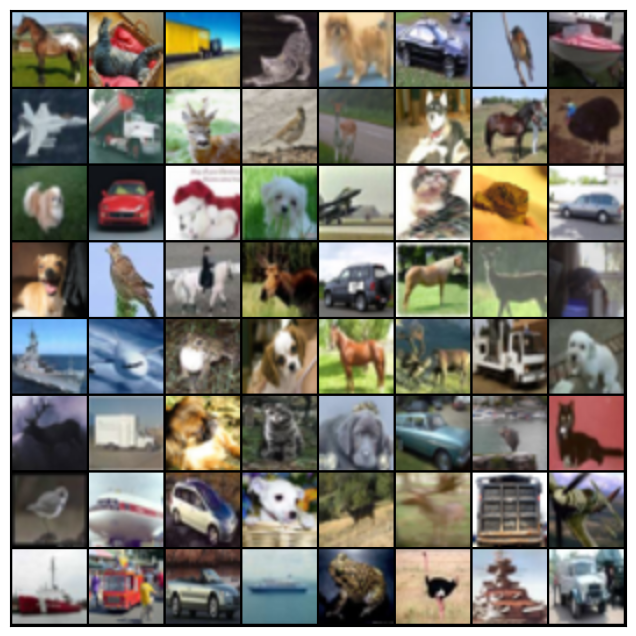

In [7]:
show_batch(train_dl)

# Use the GPU

In [8]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [9]:
device = get_default_device()
device

device(type='cuda')

In [10]:
#Load training data on GPU
train_dl = DeviceDataLoader(train_dl, device)

In [11]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [12]:
discriminator = to_device(discriminator, device)
print(discriminator)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

# Generator Network

In [13]:
latent_size = 128

In [14]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [15]:
generator = to_device(generator, device)
print(generator)

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)


# Discriminator network

In [16]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

# Generator Training

In [17]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [18]:
sample_dir = 'generated2'
os.makedirs(sample_dir, exist_ok=True)

In [19]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [20]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

# Full training

In [21]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [22]:
lr = 0.0002
epochs = 75

# start the training

In [24]:
history = fit(epochs, lr)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/75], loss_g: 6.5572, loss_d: 0.0070, real_score: 0.9970, fake_score: 0.0039
Saving generated-images-0001.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/75], loss_g: 2.7917, loss_d: 0.5464, real_score: 0.7675, fake_score: 0.1992
Saving generated-images-0002.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/75], loss_g: 3.9253, loss_d: 0.2403, real_score: 0.8311, fake_score: 0.0325
Saving generated-images-0003.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/75], loss_g: 1.8988, loss_d: 0.3869, real_score: 0.8540, fake_score: 0.1763
Saving generated-images-0004.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/75], loss_g: 6.2327, loss_d: 0.4654, real_score: 0.9456, fake_score: 0.3043
Saving generated-images-0005.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6/75], loss_g: 2.0071, loss_d: 0.4129, real_score: 0.7565, fake_score: 0.0924
Saving generated-images-0006.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7/75], loss_g: 6.9113, loss_d: 0.0147, real_score: 0.9877, fake_score: 0.0022
Saving generated-images-0007.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8/75], loss_g: 3.6315, loss_d: 0.0782, real_score: 0.9840, fake_score: 0.0586
Saving generated-images-0008.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9/75], loss_g: 4.3230, loss_d: 0.0864, real_score: 0.9368, fake_score: 0.0178
Saving generated-images-0009.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10/75], loss_g: 5.5986, loss_d: 0.2338, real_score: 0.8186, fake_score: 0.0036
Saving generated-images-0010.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [11/75], loss_g: 4.1668, loss_d: 0.3672, real_score: 0.8955, fake_score: 0.1974
Saving generated-images-0011.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [12/75], loss_g: 0.4454, loss_d: 1.3952, real_score: 0.3105, fake_score: 0.0042
Saving generated-images-0012.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [13/75], loss_g: 9.2979, loss_d: 0.5110, real_score: 0.9823, fake_score: 0.3419
Saving generated-images-0013.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [14/75], loss_g: 6.1805, loss_d: 0.0203, real_score: 0.9833, fake_score: 0.0033
Saving generated-images-0014.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [15/75], loss_g: 5.9636, loss_d: 0.1433, real_score: 0.8814, fake_score: 0.0048
Saving generated-images-0015.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [16/75], loss_g: 5.6421, loss_d: 0.2711, real_score: 0.9875, fake_score: 0.2116
Saving generated-images-0016.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [17/75], loss_g: 2.9943, loss_d: 0.4648, real_score: 0.8388, fake_score: 0.2091
Saving generated-images-0017.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [18/75], loss_g: 3.5819, loss_d: 0.0851, real_score: 0.9677, fake_score: 0.0482
Saving generated-images-0018.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [19/75], loss_g: 5.2696, loss_d: 0.1027, real_score: 0.9248, fake_score: 0.0186
Saving generated-images-0019.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [20/75], loss_g: 5.5316, loss_d: 0.0143, real_score: 0.9900, fake_score: 0.0041
Saving generated-images-0020.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [21/75], loss_g: 10.6424, loss_d: 0.0331, real_score: 0.9686, fake_score: 0.0000
Saving generated-images-0021.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [22/75], loss_g: 3.7214, loss_d: 0.1164, real_score: 0.9619, fake_score: 0.0674
Saving generated-images-0022.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [23/75], loss_g: 5.7918, loss_d: 0.0256, real_score: 0.9880, fake_score: 0.0131
Saving generated-images-0023.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [24/75], loss_g: 2.1456, loss_d: 0.1748, real_score: 0.9553, fake_score: 0.1048
Saving generated-images-0024.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [25/75], loss_g: 3.9402, loss_d: 0.1137, real_score: 0.9437, fake_score: 0.0501
Saving generated-images-0025.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [26/75], loss_g: 9.3905, loss_d: 0.0011, real_score: 0.9990, fake_score: 0.0001
Saving generated-images-0026.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [27/75], loss_g: 9.8575, loss_d: 0.0009, real_score: 0.9992, fake_score: 0.0001
Saving generated-images-0027.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [28/75], loss_g: 9.6465, loss_d: 0.0900, real_score: 0.9977, fake_score: 0.0516
Saving generated-images-0028.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [29/75], loss_g: 7.6545, loss_d: 0.0632, real_score: 0.9429, fake_score: 0.0010
Saving generated-images-0029.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [30/75], loss_g: 8.2191, loss_d: 0.0101, real_score: 0.9915, fake_score: 0.0015
Saving generated-images-0030.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [31/75], loss_g: 7.9811, loss_d: 0.0277, real_score: 0.9762, fake_score: 0.0024
Saving generated-images-0031.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [32/75], loss_g: 6.0961, loss_d: 0.0510, real_score: 0.9996, fake_score: 0.0473
Saving generated-images-0032.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [33/75], loss_g: 5.7696, loss_d: 0.0927, real_score: 0.9897, fake_score: 0.0706
Saving generated-images-0033.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [34/75], loss_g: 4.5238, loss_d: 0.1873, real_score: 0.9157, fake_score: 0.0732
Saving generated-images-0034.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [35/75], loss_g: 5.5034, loss_d: 0.1143, real_score: 0.9780, fake_score: 0.0773
Saving generated-images-0035.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [36/75], loss_g: 6.5752, loss_d: 0.2844, real_score: 0.9536, fake_score: 0.1311
Saving generated-images-0036.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [37/75], loss_g: 8.9735, loss_d: 0.0287, real_score: 0.9984, fake_score: 0.0230
Saving generated-images-0037.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [38/75], loss_g: 3.8710, loss_d: 0.1475, real_score: 0.9057, fake_score: 0.0306
Saving generated-images-0038.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [39/75], loss_g: 8.0739, loss_d: 0.7882, real_score: 1.0000, fake_score: 0.4030
Saving generated-images-0039.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [40/75], loss_g: 3.3629, loss_d: 0.1304, real_score: 0.9254, fake_score: 0.0422
Saving generated-images-0040.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [41/75], loss_g: 4.4260, loss_d: 0.0508, real_score: 0.9845, fake_score: 0.0336
Saving generated-images-0041.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [42/75], loss_g: 3.7266, loss_d: 0.2933, real_score: 0.8266, fake_score: 0.0184
Saving generated-images-0042.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [43/75], loss_g: 5.6654, loss_d: 0.0390, real_score: 0.9761, fake_score: 0.0108
Saving generated-images-0043.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [44/75], loss_g: 6.1243, loss_d: 0.1064, real_score: 0.9802, fake_score: 0.0782
Saving generated-images-0044.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [45/75], loss_g: 4.7188, loss_d: 0.0282, real_score: 0.9885, fake_score: 0.0163
Saving generated-images-0045.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [46/75], loss_g: 4.8080, loss_d: 0.0944, real_score: 0.9972, fake_score: 0.0833
Saving generated-images-0046.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [47/75], loss_g: 6.1257, loss_d: 0.0142, real_score: 0.9939, fake_score: 0.0079
Saving generated-images-0047.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [48/75], loss_g: 6.5425, loss_d: 0.4206, real_score: 0.9558, fake_score: 0.2756
Saving generated-images-0048.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [49/75], loss_g: 5.7002, loss_d: 0.1075, real_score: 0.9775, fake_score: 0.0635
Saving generated-images-0049.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [50/75], loss_g: 6.5991, loss_d: 0.0073, real_score: 0.9984, fake_score: 0.0055
Saving generated-images-0050.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [51/75], loss_g: 5.4266, loss_d: 0.1405, real_score: 0.9980, fake_score: 0.1127
Saving generated-images-0051.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [52/75], loss_g: 7.6080, loss_d: 0.0058, real_score: 0.9959, fake_score: 0.0017
Saving generated-images-0052.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [53/75], loss_g: 6.1024, loss_d: 0.0217, real_score: 0.9999, fake_score: 0.0206
Saving generated-images-0053.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [54/75], loss_g: 2.3329, loss_d: 0.1189, real_score: 0.9120, fake_score: 0.0203
Saving generated-images-0054.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [55/75], loss_g: 6.5027, loss_d: 0.0065, real_score: 0.9953, fake_score: 0.0018
Saving generated-images-0055.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [56/75], loss_g: 6.1332, loss_d: 0.0414, real_score: 0.9768, fake_score: 0.0171
Saving generated-images-0056.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [57/75], loss_g: 6.5289, loss_d: 0.0624, real_score: 0.9837, fake_score: 0.0420
Saving generated-images-0057.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [58/75], loss_g: 9.0517, loss_d: 0.0145, real_score: 0.9863, fake_score: 0.0004
Saving generated-images-0058.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [59/75], loss_g: 4.8899, loss_d: 0.0144, real_score: 0.9970, fake_score: 0.0112
Saving generated-images-0059.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [60/75], loss_g: 6.3465, loss_d: 0.0095, real_score: 0.9966, fake_score: 0.0060
Saving generated-images-0060.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [61/75], loss_g: 12.2709, loss_d: 0.1343, real_score: 0.9928, fake_score: 0.1088
Saving generated-images-0061.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [62/75], loss_g: 5.3505, loss_d: 0.0742, real_score: 0.9496, fake_score: 0.0127
Saving generated-images-0062.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [63/75], loss_g: 5.4988, loss_d: 0.0349, real_score: 0.9886, fake_score: 0.0220
Saving generated-images-0063.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [64/75], loss_g: 4.4583, loss_d: 0.0995, real_score: 0.9589, fake_score: 0.0493
Saving generated-images-0064.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [65/75], loss_g: 4.2390, loss_d: 0.2655, real_score: 0.8728, fake_score: 0.0835
Saving generated-images-0065.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [66/75], loss_g: 5.3202, loss_d: 0.1348, real_score: 0.9355, fake_score: 0.0441
Saving generated-images-0066.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [67/75], loss_g: 6.0830, loss_d: 0.0685, real_score: 0.9510, fake_score: 0.0059
Saving generated-images-0067.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [68/75], loss_g: 5.3246, loss_d: 0.0721, real_score: 0.9811, fake_score: 0.0468
Saving generated-images-0068.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [69/75], loss_g: 8.4760, loss_d: 0.0081, real_score: 0.9924, fake_score: 0.0003
Saving generated-images-0069.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [70/75], loss_g: 4.9476, loss_d: 0.1670, real_score: 0.9950, fake_score: 0.1395
Saving generated-images-0070.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [71/75], loss_g: 6.7161, loss_d: 0.0208, real_score: 0.9818, fake_score: 0.0019
Saving generated-images-0071.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [72/75], loss_g: 3.7423, loss_d: 0.1355, real_score: 0.9845, fake_score: 0.1019
Saving generated-images-0072.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [73/75], loss_g: 8.8183, loss_d: 0.2084, real_score: 0.9963, fake_score: 0.1433
Saving generated-images-0073.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [74/75], loss_g: 6.6942, loss_d: 0.0040, real_score: 0.9988, fake_score: 0.0027
Saving generated-images-0074.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [75/75], loss_g: 4.0169, loss_d: 0.4648, real_score: 0.7869, fake_score: 0.1304
Saving generated-images-0075.png


In [25]:
losses_g, losses_d, real_scores, fake_scores = history

In [26]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'Generative_DCGAN_local.pth')
torch.save(discriminator.state_dict(), 'Discriminator_DCGAN_local.pth')

In [27]:
vid_fname = 'gans_training1_local.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

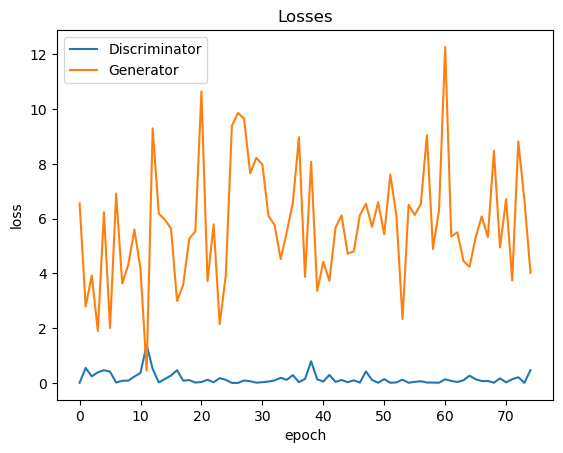

In [28]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

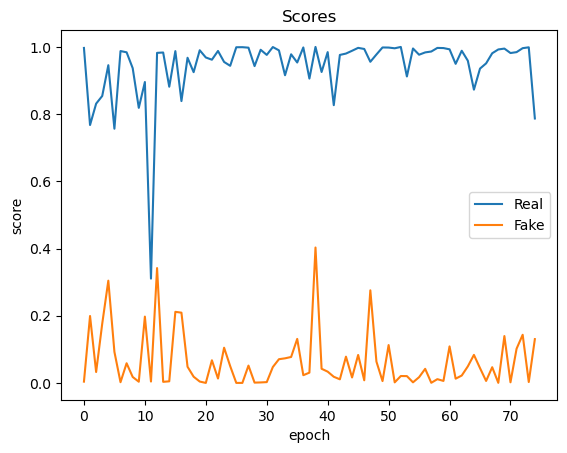

In [29]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

In [33]:
history += fit(epochs=50, lr=0.0001)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/50], loss_g: 4.2814, loss_d: 0.0841, real_score: 0.9651, fake_score: 0.0445
Saving generated-images-0001.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/50], loss_g: 3.7916, loss_d: 0.0651, real_score: 0.9693, fake_score: 0.0299
Saving generated-images-0002.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/50], loss_g: 8.7165, loss_d: 0.0499, real_score: 0.9541, fake_score: 0.0003
Saving generated-images-0003.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/50], loss_g: 8.3488, loss_d: 0.0115, real_score: 0.9895, fake_score: 0.0007
Saving generated-images-0004.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/50], loss_g: 6.9534, loss_d: 0.0363, real_score: 0.9663, fake_score: 0.0008
Saving generated-images-0005.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6/50], loss_g: 4.7033, loss_d: 0.0794, real_score: 0.9771, fake_score: 0.0522
Saving generated-images-0006.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7/50], loss_g: 4.7375, loss_d: 0.0121, real_score: 0.9932, fake_score: 0.0052
Saving generated-images-0007.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8/50], loss_g: 5.0430, loss_d: 0.0313, real_score: 0.9711, fake_score: 0.0011
Saving generated-images-0008.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9/50], loss_g: 4.9042, loss_d: 0.1323, real_score: 0.9081, fake_score: 0.0266
Saving generated-images-0009.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10/50], loss_g: 2.4451, loss_d: 0.2760, real_score: 0.8321, fake_score: 0.0563
Saving generated-images-0010.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [11/50], loss_g: 2.9278, loss_d: 0.2230, real_score: 0.9344, fake_score: 0.1228
Saving generated-images-0011.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [12/50], loss_g: 8.6455, loss_d: 0.0588, real_score: 0.9462, fake_score: 0.0001
Saving generated-images-0012.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [13/50], loss_g: 6.9742, loss_d: 0.0090, real_score: 0.9965, fake_score: 0.0054
Saving generated-images-0013.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [14/50], loss_g: 6.3303, loss_d: 0.0104, real_score: 0.9962, fake_score: 0.0065
Saving generated-images-0014.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [15/50], loss_g: 5.8871, loss_d: 0.0113, real_score: 0.9964, fake_score: 0.0075
Saving generated-images-0015.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [16/50], loss_g: 2.5688, loss_d: 0.2595, real_score: 0.8316, fake_score: 0.0414
Saving generated-images-0016.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [17/50], loss_g: 7.4881, loss_d: 0.0193, real_score: 0.9817, fake_score: 0.0002
Saving generated-images-0017.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [18/50], loss_g: 7.1224, loss_d: 0.0157, real_score: 0.9884, fake_score: 0.0036
Saving generated-images-0018.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [19/50], loss_g: 0.8605, loss_d: 1.3229, real_score: 0.3995, fake_score: 0.0004
Saving generated-images-0019.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [20/50], loss_g: 5.0058, loss_d: 0.0554, real_score: 0.9553, fake_score: 0.0052
Saving generated-images-0020.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [21/50], loss_g: 3.5930, loss_d: 0.0109, real_score: 0.9976, fake_score: 0.0084
Saving generated-images-0021.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [22/50], loss_g: 4.5217, loss_d: 0.0745, real_score: 0.9834, fake_score: 0.0505
Saving generated-images-0022.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [23/50], loss_g: 5.6688, loss_d: 0.0056, real_score: 0.9972, fake_score: 0.0028
Saving generated-images-0023.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [24/50], loss_g: 6.9956, loss_d: 0.0057, real_score: 0.9967, fake_score: 0.0023
Saving generated-images-0024.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [25/50], loss_g: 7.3485, loss_d: 0.0083, real_score: 0.9986, fake_score: 0.0067
Saving generated-images-0025.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [26/50], loss_g: 10.6815, loss_d: 0.0241, real_score: 0.9972, fake_score: 0.0200
Saving generated-images-0026.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [27/50], loss_g: 4.4030, loss_d: 0.1408, real_score: 0.9030, fake_score: 0.0185
Saving generated-images-0027.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [28/50], loss_g: 3.6121, loss_d: 0.1917, real_score: 0.9418, fake_score: 0.0968
Saving generated-images-0028.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [29/50], loss_g: 5.8704, loss_d: 0.0222, real_score: 0.9988, fake_score: 0.0199
Saving generated-images-0029.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [30/50], loss_g: 7.4813, loss_d: 0.0154, real_score: 0.9859, fake_score: 0.0009
Saving generated-images-0030.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [31/50], loss_g: 2.6542, loss_d: 0.6361, real_score: 0.9933, fake_score: 0.3570
Saving generated-images-0031.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [32/50], loss_g: 5.1909, loss_d: 0.0591, real_score: 0.9588, fake_score: 0.0091
Saving generated-images-0032.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [33/50], loss_g: 5.2034, loss_d: 0.0345, real_score: 0.9801, fake_score: 0.0136
Saving generated-images-0033.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [34/50], loss_g: 11.1719, loss_d: 0.0295, real_score: 0.9719, fake_score: 0.0001
Saving generated-images-0034.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [35/50], loss_g: 6.3271, loss_d: 0.0072, real_score: 0.9996, fake_score: 0.0067
Saving generated-images-0035.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [36/50], loss_g: 5.3016, loss_d: 0.0209, real_score: 0.9850, fake_score: 0.0054
Saving generated-images-0036.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [37/50], loss_g: 5.1804, loss_d: 0.0156, real_score: 0.9981, fake_score: 0.0133
Saving generated-images-0037.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [38/50], loss_g: 1.8063, loss_d: 0.4368, real_score: 0.7297, fake_score: 0.0221
Saving generated-images-0038.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [39/50], loss_g: 7.1068, loss_d: 0.0152, real_score: 0.9939, fake_score: 0.0089
Saving generated-images-0039.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [40/50], loss_g: 4.4871, loss_d: 0.1241, real_score: 0.9794, fake_score: 0.0887
Saving generated-images-0040.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [41/50], loss_g: 3.6276, loss_d: 0.1475, real_score: 0.9025, fake_score: 0.0229
Saving generated-images-0041.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [42/50], loss_g: 5.3566, loss_d: 0.0990, real_score: 0.9616, fake_score: 0.0513
Saving generated-images-0042.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [43/50], loss_g: 4.6774, loss_d: 0.2327, real_score: 0.8290, fake_score: 0.0045
Saving generated-images-0043.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [44/50], loss_g: 10.6601, loss_d: 0.0129, real_score: 0.9874, fake_score: 0.0001
Saving generated-images-0044.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [45/50], loss_g: 4.7391, loss_d: 0.0606, real_score: 0.9745, fake_score: 0.0301
Saving generated-images-0045.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [46/50], loss_g: 5.3229, loss_d: 0.1371, real_score: 0.9703, fake_score: 0.0882
Saving generated-images-0046.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [47/50], loss_g: 6.6990, loss_d: 0.0484, real_score: 0.9808, fake_score: 0.0259
Saving generated-images-0047.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [48/50], loss_g: 3.2962, loss_d: 0.1967, real_score: 0.8998, fake_score: 0.0609
Saving generated-images-0048.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [49/50], loss_g: 4.3175, loss_d: 0.1562, real_score: 0.8836, fake_score: 0.0165
Saving generated-images-0049.png


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [50/50], loss_g: 7.1111, loss_d: 0.0085, real_score: 0.9959, fake_score: 0.0042
Saving generated-images-0050.png
